<a href="https://colab.research.google.com/github/madhugoutham/Stock_Price_Prediction/blob/main/Stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade --force-reinstall scikit-learn==1.3.1 xgboost==1.7.6

In [ ]:
!pip install yfinance

In [ ]:
# If you don't have yfinance installed:
# !pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# For splitting & model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Ignore warnings for cleaner output (optional)
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [ ]:
# Define ticker and date range
ticker = "TSLA"
start_date = "2016-01-01"
end_date = "2021-12-31"

# Fetch data
df = yf.download(ticker, start=start_date, end=end_date)
print("Data shape:", df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed

Data shape: (1510, 5)


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2016-01-04,14.894000,15.425333,14.600000,15.381333,102406500
2016-01-05,14.895333,15.126000,14.666667,15.090667,47802000
2016-01-06,14.602667,14.670000,14.398667,14.666667,56686500
2016-01-07,14.376667,14.562667,14.244667,14.279333,53314500
2016-01-08,14.066667,14.696000,14.051333,14.524000,54421500


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2016-01-04 to 2021-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   1510 non-null   float64
 1   (High, TSLA)    1510 non-null   float64
 2   (Low, TSLA)     1510 non-null   float64
 3   (Open, TSLA)    1510 non-null   float64
 4   (Volume, TSLA)  1510 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


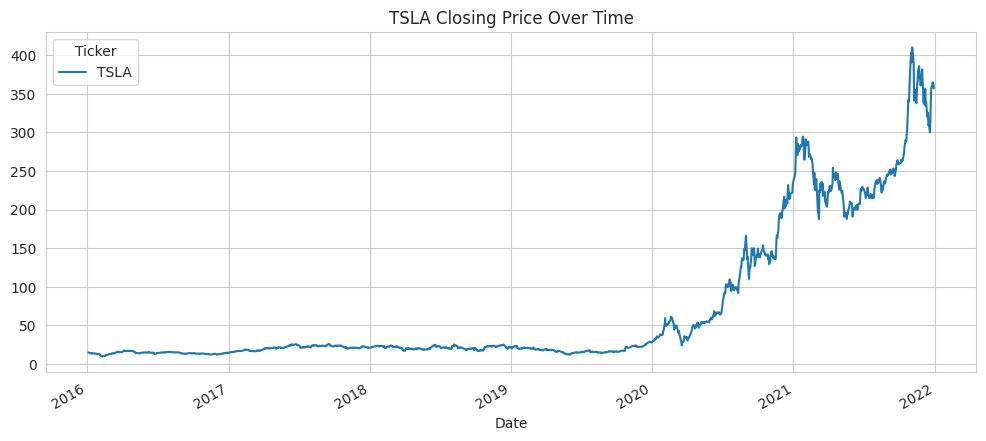

In [ ]:
df.info()  # Check data types and missing values
df.describe()  # Basic stats

# Quick visualization of the closing price over time
df['Close'].plot(title=f"{ticker} Closing Price Over Time", figsize=(12,5))
plt.show()

In [ ]:
df['Close_Target'] = df['Close'].shift(-1)  # Next day's close

In [ ]:
# 5-day Moving Average of Close
df['MA5'] = df['Close'].rolling(window=5).mean()

# 10-day Moving Average of Close
df['MA10'] = df['Close'].rolling(window=10).mean()

In [ ]:
df.dropna(inplace=True)
print("Data shape after dropping NaNs:", df.shape)
df.head()

Data shape after dropping NaNs: (1500, 8)


Price,Close,High,Low,Open,Volume,Close_Target,MA5,MA10
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,
Date,,,,,,,,
2016-01-15,13.666000,13.671333,13.150000,13.264667,83679000,13.648000,13.724000,14.145533
2016-01-19,13.648000,14.031333,13.385333,13.914000,60580500,13.246667,13.682267,14.020933
2016-01-20,13.246667,13.418667,12.750000,13.293333,87579000,13.331333,13.532000,13.856067
2016-01-21,13.331333,13.548667,13.001333,13.436667,47493000,13.503333,13.527467,13.728933
2016-01-22,13.503333,13.700000,13.268667,13.653333,46861500,13.092000,13.479067,13.641600


In [ ]:
# Let's choose all data before 2021 as training, and 2021 as testing.
split_date = "2021-01-01"

df_train = df.loc[df.index < split_date].copy()
df_test = df.loc[df.index >= split_date].copy()

print("Train data range:", df_train.index.min(), "to", df_train.index.max())
print("Test data range:", df_test.index.min(), "to", df_test.index.max())

# Features we want to use for training
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10']
target_col = 'Close_Target'

X_train = df_train[feature_cols]
y_train = df_train[target_col]

X_test = df_test[feature_cols]
y_test = df_test[target_col]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Train data range: 2016-01-15 00:00:00 to 2020-12-31 00:00:00
Test data range: 2021-01-04 00:00:00 to 2021-12-29 00:00:00
Training samples: 1250
Testing samples: 250


In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return mae, mse, rmse, r2

mae_dt, mse_dt, rmse_dt, r2_dt = evaluate_model(dt, X_test, y_test)
print("Decision Tree Regressor Performance:")
print(f"MAE: {mae_dt:.2f}")
print(f"MSE: {mse_dt:.2f}")
print(f"RMSE: {rmse_dt:.2f}")
print(f"R^2: {r2_dt:.4f}")

Decision Tree Regressor Performance:
MAE: 33.84
MSE: 2853.38
RMSE: 53.42
R^2: 0.0038


In [ ]:
param_grid_dt = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("Best Decision Tree params:", grid_dt.best_params_)

mae_dt_best, mse_dt_best, rmse_dt_best, r2_dt_best = evaluate_model(best_dt, X_test, y_test)
print("Tuned Decision Tree Regressor Performance:")
print(f"MAE: {mae_dt_best:.2f}")
print(f"MSE: {mse_dt_best:.2f}")
print(f"RMSE: {rmse_dt_best:.2f}")
print(f"R^2: {r2_dt_best:.4f}")

Best Decision Tree params: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Decision Tree Regressor Performance:
MAE: 36.65
MSE: 3279.39
RMSE: 57.27
R^2: -0.1450


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
mae_rf, mse_rf, rmse_rf, r2_rf = evaluate_model(rf, X_test, y_test)

print("Random Forest Regressor Performance:")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R^2: {r2_rf:.4f}")

Random Forest Regressor Performance:
MAE: 34.87
MSE: 3135.64
RMSE: 56.00
R^2: -0.0948


In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best Random Forest params:", grid_rf.best_params_)

mae_rf_best, mse_rf_best, rmse_rf_best, r2_rf_best = evaluate_model(best_rf, X_test, y_test)
print("Tuned Random Forest Regressor Performance:")
print(f"MAE: {mae_rf_best:.2f}")
print(f"MSE: {mse_rf_best:.2f}")
print(f"RMSE: {rmse_rf_best:.2f}")
print(f"R^2: {r2_rf_best:.4f}")

Best Random Forest params: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Regressor Performance:
MAE: 34.73
MSE: 3123.24
RMSE: 55.89
R^2: -0.0904


In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
mae_gb, mse_gb, rmse_gb, r2_gb = evaluate_model(gb, X_test, y_test)

print("Gradient Boosting Regressor Performance:")
print(f"MAE: {mae_gb:.2f}")
print(f"MSE: {mse_gb:.2f}")
print(f"RMSE: {rmse_gb:.2f}")
print(f"R^2: {r2_gb:.4f}")

Gradient Boosting Regressor Performance:
MAE: 34.34
MSE: 3018.02
RMSE: 54.94
R^2: -0.0537


In [ ]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_
print("Best Gradient Boosting params:", grid_gb.best_params_)

mae_gb_best, mse_gb_best, rmse_gb_best, r2_gb_best = evaluate_model(best_gb, X_test, y_test)
print("Tuned Gradient Boosting Regressor Performance:")
print(f"MAE: {mae_gb_best:.2f}")
print(f"MSE: {mse_gb_best:.2f}")
print(f"RMSE: {rmse_gb_best:.2f}")
print(f"R^2: {r2_gb_best:.4f}")

Best Gradient Boosting params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Tuned Gradient Boosting Regressor Performance:
MAE: 34.27
MSE: 3017.23
RMSE: 54.93
R^2: -0.0534


In [ ]:
xgb_reg = XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=42)
xgb_reg.fit(X_train, y_train)
mae_xgb, mse_xgb, rmse_xgb, r2_xgb = evaluate_model(xgb_reg, X_test, y_test)

print("XGBoost Regressor Performance:")
print(f"MAE: {mae_xgb:.2f}")
print(f"MSE: {mse_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R^2: {r2_xgb:.4f}")

XGBoost Regressor Performance:
MAE: 35.70
MSE: 3212.84
RMSE: 56.68
R^2: -0.1217


In [ ]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_xgb = GridSearchCV(
    XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("Best XGBoost params:", grid_xgb.best_params_)

mae_xgb_best, mse_xgb_best, rmse_xgb_best, r2_xgb_best = evaluate_model(best_xgb, X_test, y_test)
print("Tuned XGBoost Regressor Performance:")
print(f"MAE: {mae_xgb_best:.2f}")
print(f"MSE: {mse_xgb_best:.2f}")
print(f"RMSE: {rmse_xgb_best:.2f}")
print(f"R^2: {r2_xgb_best:.4f}")

Best XGBoost params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Tuned XGBoost Regressor Performance:
MAE: 35.92
MSE: 3265.07
RMSE: 57.14
R^2: -0.1400


In [ ]:
models_perf = {
    "DecisionTree": [mae_dt_best, mse_dt_best, rmse_dt_best, r2_dt_best],
    "RandomForest": [mae_rf_best, mse_rf_best, rmse_rf_best, r2_rf_best],
    "GradientBoosting": [mae_gb_best, mse_gb_best, rmse_gb_best, r2_gb_best],
    "XGBoost": [mae_xgb_best, mse_xgb_best, rmse_xgb_best, r2_xgb_best]
}

df_perf = pd.DataFrame(models_perf, index=["MAE","MSE","RMSE","R^2"])
df_perf

,DecisionTree,RandomForest,GradientBoosting,XGBoost
MAE,36.648160,34.734894,34.269809,35.917482
MSE,3279.392601,3123.237214,3017.233101,3265.074574
RMSE,57.265981,55.885930,54.929346,57.140831
R^2,-0.144959,-0.090439,-0.053429,-0.139960


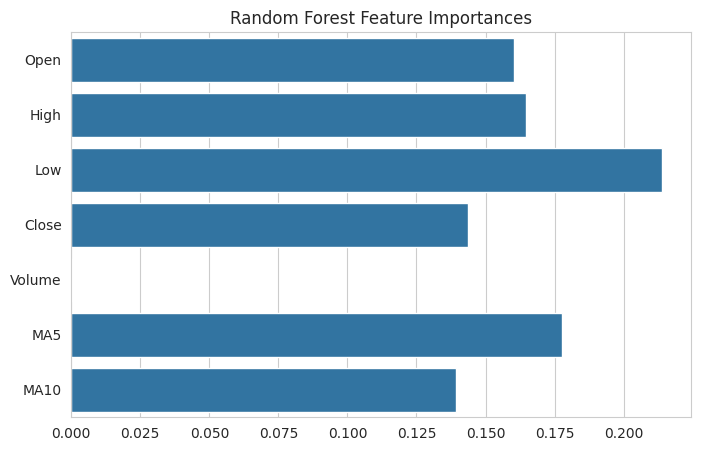

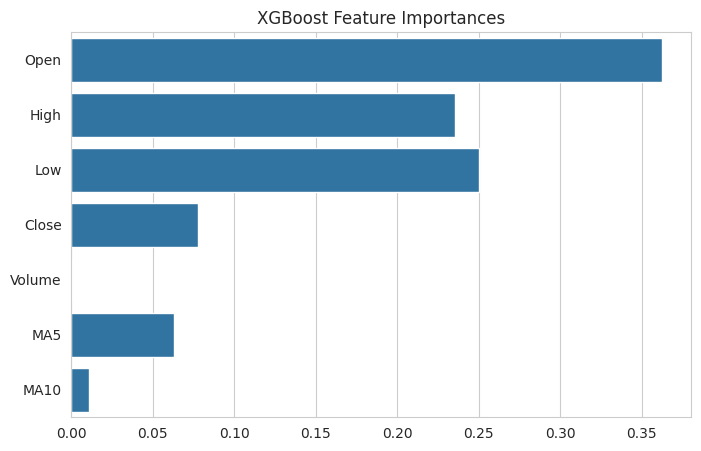

In [ ]:
# Example: Random Forest
importances_rf = best_rf.feature_importances_
feature_names = feature_cols

plt.figure(figsize=(8,5))
sns.barplot(x=importances_rf, y=feature_names)
plt.title("Random Forest Feature Importances")
plt.show()

# Example: XGBoost
importances_xgb = best_xgb.feature_importances_

plt.figure(figsize=(8,5))
sns.barplot(x=importances_xgb, y=feature_names)
plt.title("XGBoost Feature Importances")
plt.show()